In [173]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [174]:
# Step 2: Define function to load from a GeoTIFF file
def load_tif(filepath):
    """Load a single-band TIFF file as a numpy array."""
    with rasterio.open(filepath) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        return src.read(1), src.transform, src.crs, extent

In [175]:
def read_kml(ref_tiff_path):
    # Load the KML file
    kml_path = 'dhaka_cIty_gis_project.kml'
    kml_gdf = gpd.read_file(kml_path, driver="KML", allow_unsupported_drivers=True)

    with rasterio.open(ref_tiff_path) as src:
        ref_crs = src.crs

    # Reproject the KML to match the TIFF CRS
    if kml_gdf.crs != ref_crs:
        kml_gdf = kml_gdf.to_crs(ref_crs)

    return kml_gdf

In [176]:
def scale(tiff_image): 
    return -1 + 2 * (tiff_image - tiff_image.min()) / (tiff_image.max() - tiff_image.min())

In [177]:
def calc_ndbi(swir_band_path, nir_band_path, year, output_path):
    # Step 4: Load SWIR and NIR bands
    swir, transform, crs, extent = load_tif(swir_band_path)
    nir, _, _, _ = load_tif(nir_band_path)
    kml_gdf = read_kml(nir_band_path)

    # Step 5: Calculate NDBI
    ndbi = (swir - nir) / (swir + nir)
    ndbi = scale(ndbi)

    # Step 6: Visualize the NDBI
    plt.figure(figsize=(10, 10))
    plt.imshow(ndbi, cmap='RdYlGn', extent=extent)  # Red-Yellow-Green colormap for built-up visualization
    plt.colorbar(label="NDBI")
    plt.title(f"Normalized Difference Built-up Index (NDBI) {year}")
    plt.axis('off')  # Hide axis for a cleaner visualization

    # Overlay the KML polygons
    kml_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=6)

    output_path = output_path + year + "/NDBI_" + year
    output_tiff = output_path + ".tif"
    output_png = output_path + ".png"

     # Save NDBI as GeoTIFF
    metadata = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': ndbi.shape[1],
        'height': ndbi.shape[0],
        'count': 1,
        'crs': crs,
        'transform': transform,
    }
    with rasterio.open(output_tiff, 'w', **metadata) as dst:
        dst.write(ndbi.astype('float32'), 1)  # Save as first band

    plt.savefig(output_png, dpi=300, bbox_inches='tight')

    plt.show()
    
    print(f"NDBI saved to {output_path}")



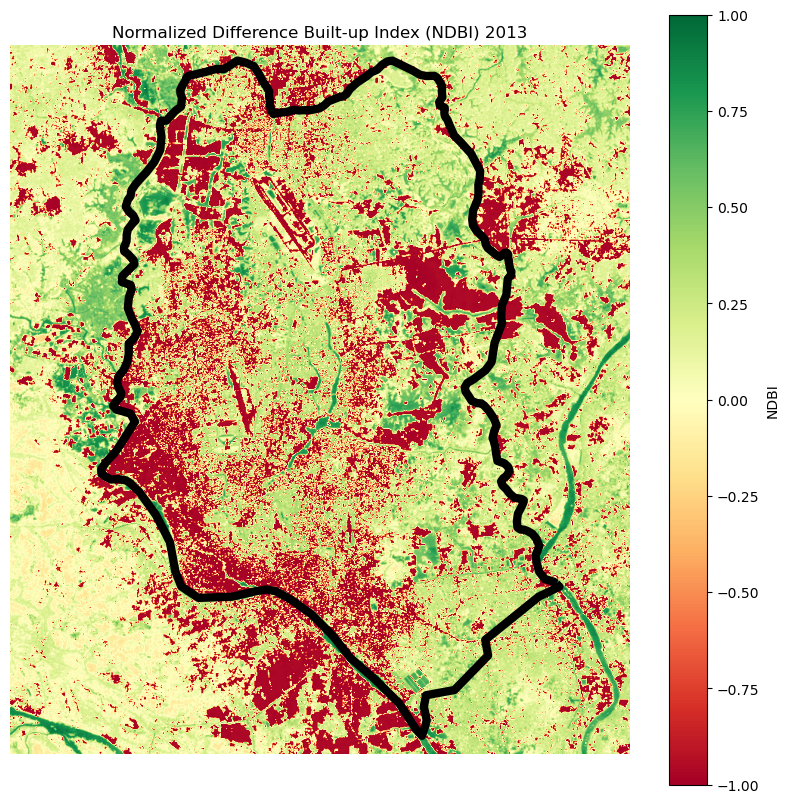

NDBI saved to ./Landsat8/output/2013/NDBI_2013


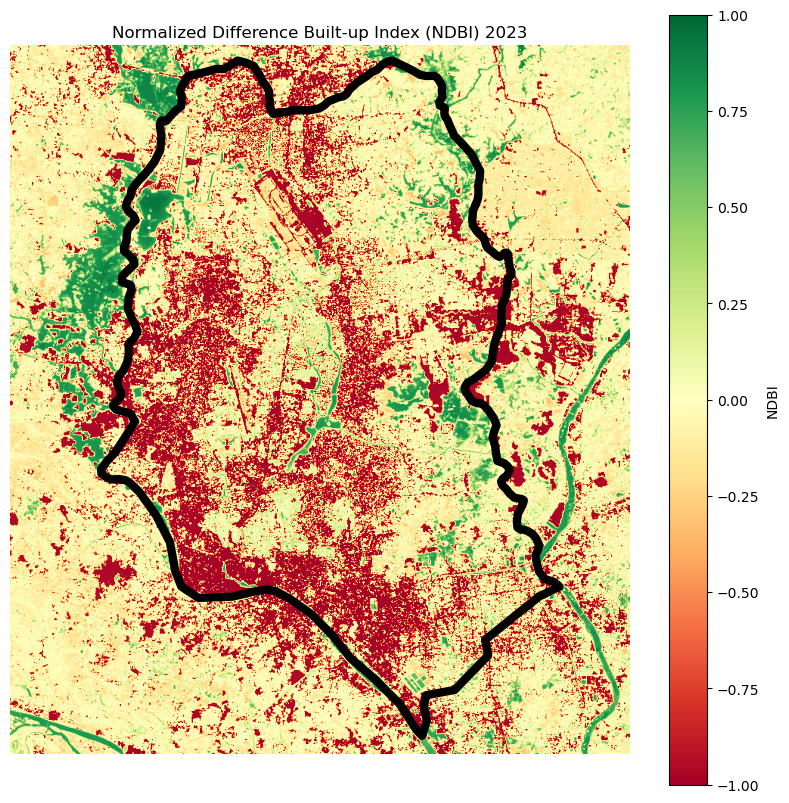

NDBI saved to ./Landsat8/output/2023/NDBI_2023


In [178]:
ROOT = './Landsat8/cropped_bbox/'
OUTPUT_PATH = './Landsat8/output/'


# Set paths to SWIR and NIR bands (modify these paths based on your data location)
# e.g., SWIR1 for Landsat 8 (Band 6)
swir_band_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B6.TIF'  

# e.g., NIR for Landsat 8 (Band 5)
nir_band_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B5.TIF'

calc_ndbi(swir_band_path_2013, nir_band_path_2013, '2013', OUTPUT_PATH)

swir_band_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B6.TIF'  
nir_band_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B5.TIF'

calc_ndbi(swir_band_path_2023, nir_band_path_2023, '2023', OUTPUT_PATH)

